# eTe ML Classificaiton Problem & its steps

We will be using the MNIST dataset, which is a set of 70,000 small
images of digits handwritten by high school students and employees of the US
Census Bureau. Each image is labeled with the digit it represents. This set has
been studied so much that it is often called the “hello world” of machine learning:
whenever people come up with a new classification algorithm they are curious to see
how it will perform on MNIST, and anyone who learns machine learning tackles this
dataset sooner or later.

In [61]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', as_frame=False)

/Users/archit3ct/anaconda3/envs/AI-Mac/lib/python3.10/site-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [62]:
X, y = mnist.data, mnist.target

In [63]:
X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [64]:
y

array(['5', '0', '4', ..., '4', '5', '6'], dtype=object)

In [65]:
X.shape

(70000, 784)

In [66]:
y.shape

(70000,)

There are 70,000 images, and each image has 784 fives. This is because each image
is 28 × 28 pixels, and each five simply represents one pixel’s intensity, from 0
(white) to 255 (black).

All we need to do is grab an instance’s five vector, reshape it to a 28 × 28 array,
and display it using Matplotlib’s imshow() function. We use cmap="binary" to get a
grayscale color map where 0 is white and 255 is black:

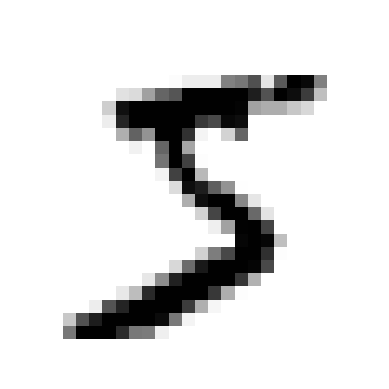

In [67]:
import matplotlib.pyplot as plt

def plot_digit(image_data):
    image = image_data.reshape(28, 28)
    plt.imshow(image, cmap="binary")
    plt.axis("off")

five = X[0]
plot_digit(five)
plt.show()

Checking What the label says is it:

In [68]:
y[0]

'5'

You should always create a test set and set it aside before inspecting the data
closely

The MNIST dataset returned by fetch_openml() is actually already split into
a training set (the first 60,000 images) and a test set (the last 10,000 images)

In [69]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

The training set is already shuffled for us, which is good because this guarantees
that all cross-validation folds will be similar (we don’t want one fold to be missing
some digits). Moreover, some learning algorithms are sensitive to the order of the
training instances, and they perform poorly if they get many similar instances in a
row. Shuffling the dataset ensures that this won’t happen

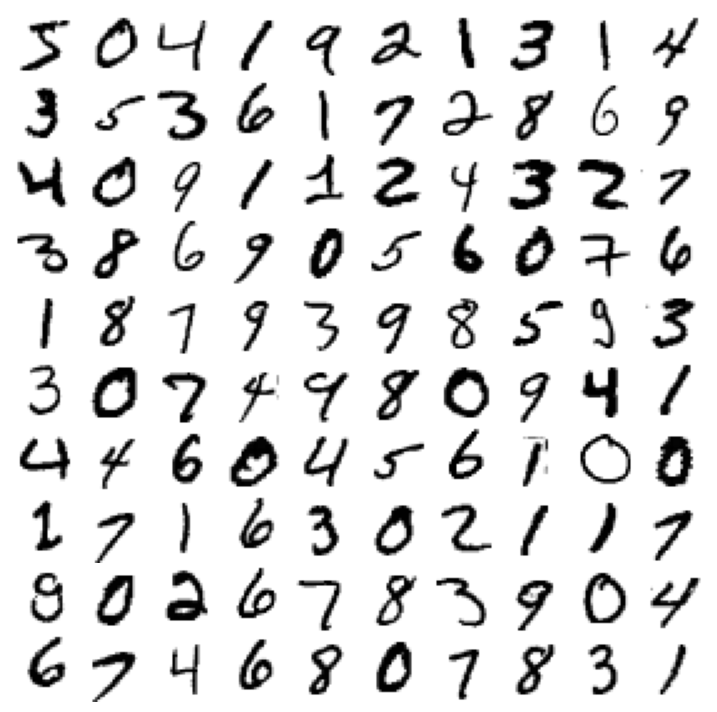

In [70]:
import matplotlib.pyplot as plt

plt.figure(figsize=(9, 9))
for idx, image_data in enumerate(X[:100]):
    plt.subplot(10, 10, idx + 1)
    plot_digit(image_data)
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

# Training a Binary Classifer

Let’s simplify the problem for now and only try to identify one digit—for example,
the number 5. This “5-detector” will be an example of a binary classifier, capable
of distinguishing between just two classes, 5 and non-5. First we’ll create the target
vectors for this classification task:

In [71]:
y_train_5 = (y_train == '5') # True for all 5s, False for all other digits
y_test_5 = (y_test == '5')

Now let’s pick a classifier and train it. A good place to start is with a stochastic gradient
descent (SGD, or stochastic GD) classifier, using Scikit-Learn’s SGDClassifier
class. This classifier is capable of handling very large datasets efficiently. This is in
part because SGD deals with training instances independently, one at a time, which
also makes SGD well suited for online learning, as you will see later. Let’s create an
SGDClassifier and train it on the whole training set:

In [72]:
from sklearn.linear_model import SGDClassifier
import sklearn

sklearn.set_config(display="diagram")
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

Now we can use it to detect images of the number 5:

In [73]:
sgd_clf.predict([five])

array([ True])

The classifier guesses that this image represents a 5 (True). Looks like it guessed right
in this particular case! Now, let’s evaluate this model’s performance.

# Performance Measure
Evaluating a classifier is often significantly trickier than evaluating a regressor

## Measuring Accuracy Using Cross-Validation

A good way to evaluate a model is to use cross-validation, Let’s use the cross_val_score() function to evaluate our SGDClassifier
model, using k-fold cross-validation with three folds. 

    Remember that k-fold crossvalidation means splitting the training set into k folds (in this case, three), then
    training the model k times, holding out a different fold each time for evaluation.

In [74]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

Wow! Above 95% accuracy (ratio of correct predictions) on all cross-validation folds?
This looks amazing, doesn’t it? Well, before you get too excited, let’s look at a dummy
classifier that just classifies every single image in the most frequent class, which in
this case is the negative class (i.e., non 5):

In [75]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier()
dummy_clf.fit(X_train, y_train_5)
print(any(dummy_clf.predict(X_train))) # prints False: no 5s detected
cross_val_score(dummy_clf, X_train, y_train_5, cv=3, scoring="accuracy")

False


array([0.90965, 0.90965, 0.90965])

That’s right, it has over 90% accuracy! This is simply because only about 10% of the
images are 5s, so if you always guess that an image is not a 5, you will be right about
90% of the time.

This demonstrates why accuracy is generally not the preferred performance measure
for classifiers, especially when you are dealing with skewed datasets (i.e., when some classes are much more frequent than others). A much better way to evaluate the
performance of a classifier is to look at the confusion matrix (CM).

# Confusion Matrices
The general idea of a confusion matrix is to count the number of times instances of
class A are classified as class B, for all A/B pairs. 

For example, to know the number of
times the classifier confused images of 8s with 0s, you would look at row #8, column
#0 of the confusion matrix.
To compute the confusion matrix, you first need to have a set of predictions so that
they can be compared to the actual targets. You could make predictions on the test
set, but it’s best to keep that untouched for now (remember that you want to use the
test set only at the very end of your project, once you have a classifier that you are
ready to launch). Instead, you can use the cross_val_predict() function:

In [76]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

    Just like the cross_val_score() function, cross_val_predict() performs k-fold
    cross-validation, but instead of returning the evaluation scores, it returns the predictions
    made on each test fold. This means that you get a clean prediction for each
    instance in the training set (by “clean” I mean “out-of-sample”: the model makes
    predictions on data that it never saw during training).

Now you are ready to get the confusion matrix using the confusion_matrix()
function. Just pass it the target classes (y_train_5) and the predicted classes
(y_train_pred):

In [77]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_train_5, y_train_pred)

cm

array([[53892,   687],
       [ 1891,  3530]])

Each row in a confusion matrix represents an actual class, while each column represents
a predicted class. The first row of this matrix considers non-5 images (the
negative class): 53,892 of them were correctly classified as non-5s (they are called true
negatives), while the remaining 687 were wrongly classified as 5s (false positives, also
called type I errors). The second row considers the images of 5s (the positive class):
1,891 were wrongly classified as non-5s (false negatives, also called type II errors),
while the remaining 3,530 were correctly classified as 5s (true positives). A perfect
classifier would only have true positives and true negatives, so its confusion matrix
would have nonzero values only on its main diagonal (top left to bottom right):

In [78]:
y_train_perfect_predictions = y_train_5 # pretend we reached perfection

In [79]:
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

How to understand the confusion matrix

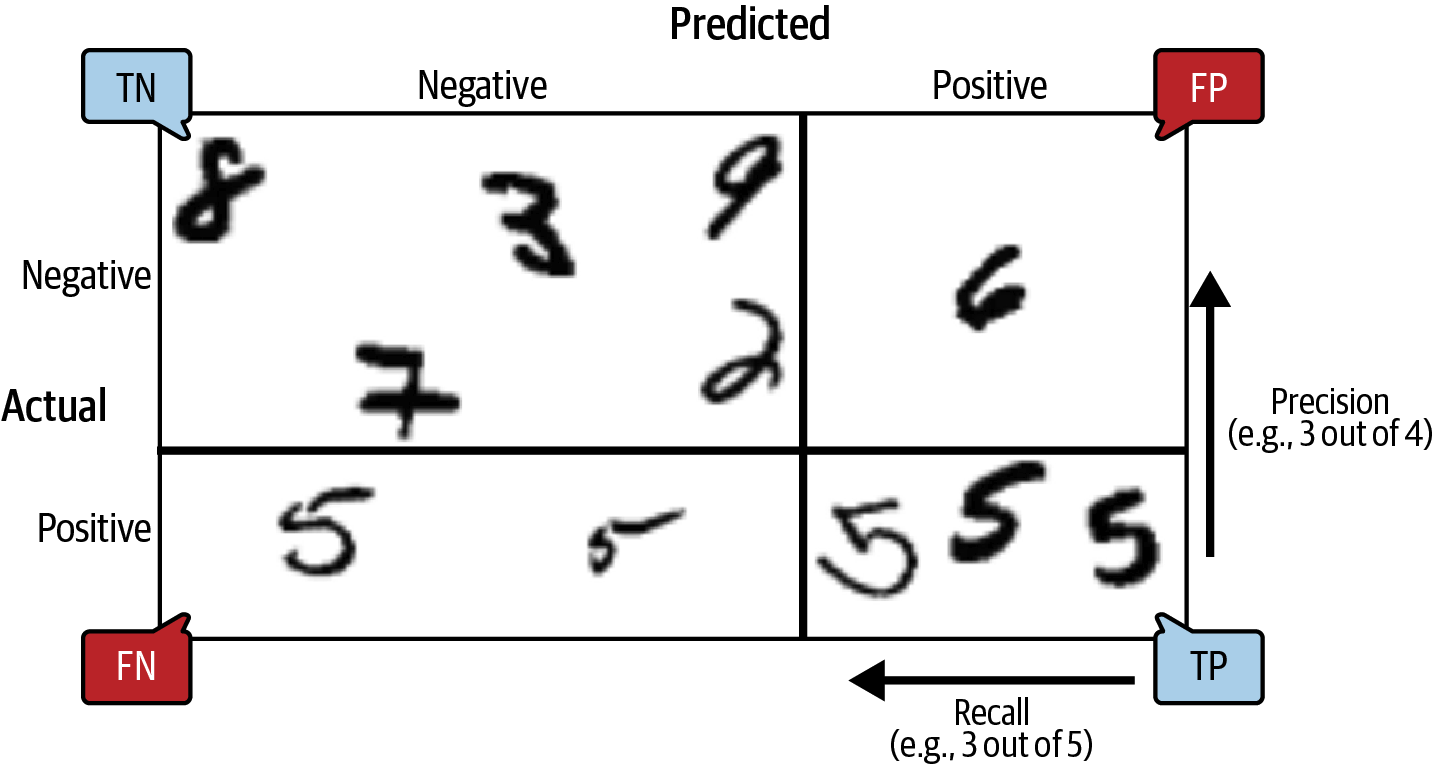

The confusion matrix gives you a lot of information, but sometimes you may prefer
a more concise metric. An interesting one to look at is the accuracy of the positive
predictions; this is called the precision of the classifier

$$\text { precision }=\frac{T P}{T P+F P}$$

$$\text { recall }=\frac{T P}{T P+F N}$$



## Precision \& Recall
Scikit-Learn provides several functions to compute classifier metrics, including precision
and recall:

In [80]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred) # == 3530 / (687 + 3530)

0.8370879772350012

In [81]:
recall_score(y_train_5, y_train_pred) # == 3530 / (1891 + 3530)

0.6511713705958311

Now our 5-detector does not look as shiny as it did when we looked at its accuracy.
When it claims an image represents a 5, it is correct only 83.7% of the time. Moreover,
it only detects 65.1% of the 5s.

It is often convenient to combine precision and recall into a single metric called the
F1 score, especially when you need a single metric to compare two classifiers. The
F1 score is the harmonic mean of precision and recall (Equation 3-3). Whereas the
regular mean treats all values equally, the harmonic mean gives much more weight to
low values. As a result, the classifier will only get a high F1 score if both recall and
precision are high.


$$
F_1 Score =\frac{2}{\frac{1}{\text { precision }}+\frac{1}{\text { recall }}}=2 \times \frac{\text { precision } \times \text { recall }}{\text { precision }+ \text { recall }}=\frac{T P}{T P+\frac{F N+F P}{2}}
$$

In [82]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7325171197343846

The F1 score favors classifiers that have similar precision and recall. This is not always
what you want: in some contexts you mostly care about precision, and in other
contexts you really care about recall.

### Balancing Precision \& Recall

    If someone says, “Let’s reach 99% precision”, you should ask, “At
    what recall?”

    Unfortunately, you can’t have it both ways: 

    increasing precision reduces recall, and vice versa. 
    This is called the precision/recall trade-off.

 For example, if you trained a classifier to detect
videos that are safe for kids, you would probably prefer a classifier that rejects many
good videos (low recall) but keeps only safe ones (high precision), rather than a
classifier that has a much higher recall but lets a few really bad videos show up in
your product (in such cases, you may even want to add a human pipeline to check
the classifier’s video selection). On the other hand, suppose you train a classifier to
detect shoplifters in surveillance images: it is probably fine if your classifier only has
30% precision as long as it has 99% recall (sure, the security guards will get a few false
alerts, but almost all shoplifters will get caught).

Example of the trade off beteween Precision \& Recall

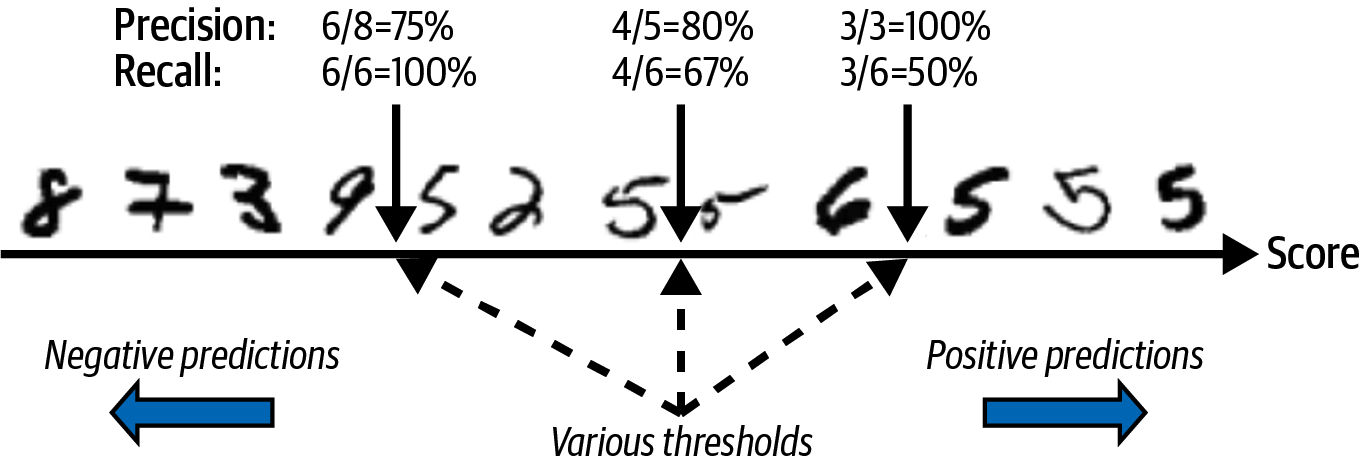

Scikit-Learn does not let you set the threshold directly, but it does give you access to
the decision scores that it uses to make predictions. Instead of calling the classifier’s
predict() method, you can call its decision_function() method, which returns a
score for each instance, and then use any threshold you want to make predictions
based on those scores:

In [83]:
y_scores = sgd_clf.decision_function([five])
y_scores

array([2164.22030239])

In [85]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

The SGDClassifier uses a threshold equal to 0, so the preceding code returns the
same result as the predict() method (i.e., True). Let’s raise the threshold:

In [87]:
threshold = 3000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

This confirms that raising the threshold decreases recall. The image actually represents
a 5, and the classifier detects it when the threshold is 0, but it misses it when the
threshold is increased to 3,000.

How do you decide which threshold to use? First, use the cross_val_predict()
function to get the scores of all instances in the training set, but this time specify that
you want to return decision scores instead of predictions:

In [88]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

With these scores, use the precision_recall_curve() function to compute precision
and recall for all possible thresholds (the function adds a last precision of 0 and a last
recall of 1, corresponding to an infinite threshold):

In [89]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

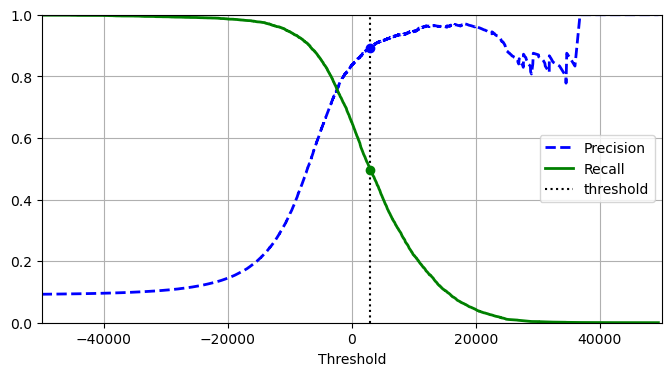

In [93]:
plt.figure(figsize=(8, 4))  # extra code – it's not needed, just formatting
plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
plt.vlines(threshold, 0, 1.0, "k", "dotted", label="threshold")

# extra code – this section just beautifies and saves Figure 3–5
idx = (thresholds >= threshold).argmax()  # first index ≥ threshold
plt.plot(thresholds[idx], precisions[idx], "bo")
plt.plot(thresholds[idx], recalls[idx], "go")
plt.axis([-50000, 50000, 0, 1])
plt.grid()
plt.xlabel("Threshold")
plt.legend(loc="center right")

plt.show()

    You may wonder why the precision curve is bumpier than the recall
    curve in Figure 3-5. The reason is that precision may sometimes go
    down when you raise the threshold (although in general it will go
    up).

At this threshold value, precision is near 90% and recall is around 50%. Another way
to select a good precision/recall trade-off is to plot precision directly against recall, as
shown in Figure 3-6 (the same threshold is shown):

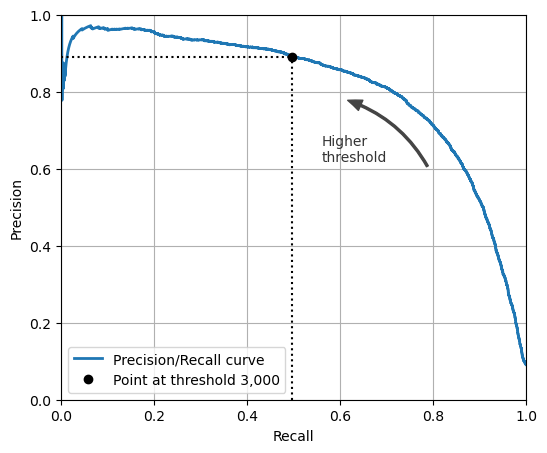

In [95]:
import matplotlib.patches as patches  # extra code – for the curved arrow

plt.figure(figsize=(6, 5))  # extra code – not needed, just formatting

plt.plot(recalls, precisions, linewidth=2, label="Precision/Recall curve")

# extra code – just beautifies and saves Figure 3–6
plt.plot([recalls[idx], recalls[idx]], [0., precisions[idx]], "k:")
plt.plot([0.0, recalls[idx]], [precisions[idx], precisions[idx]], "k:")
plt.plot([recalls[idx]], [precisions[idx]], "ko",
         label="Point at threshold 3,000")
plt.gca().add_patch(patches.FancyArrowPatch(
    (0.79, 0.60), (0.61, 0.78),
    connectionstyle="arc3,rad=.2",
    arrowstyle="Simple, tail_width=1.5, head_width=8, head_length=10",
    color="#444444"))
plt.text(0.56, 0.62, "Higher\nthreshold", color="#333333")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
plt.grid()
plt.legend(loc="lower left")

plt.show()

Figure 3-6. Precision versus recall

You can see that precision really starts to fall sharply at around 80% recall. You
will probably want to select a precision/recall trade-off just before that drop—for
example, at around 60% recall. But of course, the choice depends on your project.

Suppose you decide to aim for 90% precision. You could use the first plot to find the
threshold you need to use, but that’s not very precise. Alternatively, you can search
for the lowest threshold that gives you at least 90% precision. For this, you can use the
NumPy array’s argmax() method. This returns the first index of the maximum value,
which in this case means the first True value:

In [97]:
idx_for_90_precision = (precisions >= 0.90).argmax()
threshold_for_90_precision = thresholds[idx_for_90_precision]
threshold_for_90_precision

3370.019499144183

In [98]:
y_train_pred_90 = (y_scores >= threshold_for_90_precision)

In [99]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [100]:
recall_at_90_precision = recall_score(y_train_5, y_train_pred_90)

In [101]:
recall_at_90_precision

0.4799852425751706

Great, you have a 90% precision classifier! As you can see, it is fairly easy to create a
classifier with virtually any precision you want: just set a high enough threshold, and
you’re done. But wait, not so fast–a high-precision classifier is not very useful if its
recall is too low! For many applications, 48% recall wouldn’t be great at all.

## The ROC Curve
The receiver operating characteristic (ROC) curve is another common tool used with
binary classifiers. It is very similar to the precision/recall curve, but instead of plotting
precision versus recall, the ROC curve plots the true positive rate (another name
for recall) against the false positive rate (FPR). The FPR (also called the fall-out) is the
ratio of negative instances that are incorrectly classified as positive. It is equal to 1 –
the true negative rate (TNR), which is the ratio of negative instances that are correctly
classified as negative. The TNR is also called specificity. Hence, the ROC curve plots
sensitivity (recall) versus 1 – specificity.

In [102]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

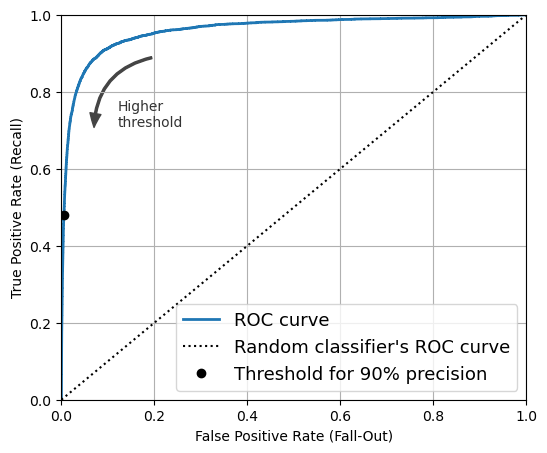

In [103]:
idx_for_threshold_at_90 = (thresholds <= threshold_for_90_precision).argmax()
tpr_90, fpr_90 = tpr[idx_for_threshold_at_90], fpr[idx_for_threshold_at_90]

plt.figure(figsize=(6, 5))  # extra code – not needed, just formatting
plt.plot(fpr, tpr, linewidth=2, label="ROC curve")
plt.plot([0, 1], [0, 1], 'k:', label="Random classifier's ROC curve")
plt.plot([fpr_90], [tpr_90], "ko", label="Threshold for 90% precision")

# extra code – just beautifies and saves Figure 3–7
plt.gca().add_patch(patches.FancyArrowPatch(
    (0.20, 0.89), (0.07, 0.70),
    connectionstyle="arc3,rad=.4",
    arrowstyle="Simple, tail_width=1.5, head_width=8, head_length=10",
    color="#444444"))
plt.text(0.12, 0.71, "Higher\nthreshold", color="#333333")
plt.xlabel('False Positive Rate (Fall-Out)')
plt.ylabel('True Positive Rate (Recall)')
plt.grid()
plt.axis([0, 1, 0, 1])
plt.legend(loc="lower right", fontsize=13)

plt.show()

A ROC curve plotting the false positive rate against the true positive rate for
all possible thresholds; the black circle highlights the chosen ratio (at 90% precision and
48% recall)

Once again there is a trade-off: the higher the recall (TPR), the more false positives
(FPR) the classifier produces. The dotted line represents the ROC curve of a purely
random classifier; a good classifier stays as far away from that line as possible (toward
the top-left corner).

One way to compare classifiers is to measure the area under the curve (AUC). A
perfect classifier will have a ROC AUC equal to 1, whereas a purely random classifier
will have a ROC AUC equal to 0.5. Scikit-Learn provides a function to estimate the
ROC AUC:

In [108]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9604938554008616

    Since the ROC curve is so similar to the precision/recall (PR)
    curve, you may wonder how to decide which one to use. As a rule
    of thumb, you should prefer the PR curve whenever the positive
    class is rare or when you care more about the false positives than
    the false negatives. Otherwise, use the ROC curve. For example,
    looking at the previous ROC curve (and the ROC AUC score),
    you may think that the classifier is really good. But this is mostly
    because there are few positives (5s) compared to the negatives
    (non-5s). In contrast, the PR curve makes it clear that the classifier
    has room for improvement: the curve could really be closer to the
    top-right corner (see Figure 3-6 again).

Let’s now create a RandomForestClassifier, whose PR curve and F1 score we can
compare to those of the SGDClassifier:

In [109]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)

The precision_recall_curve() function expects labels and scores for each
instance, so we need to train the random forest classifier and make it assign a
score to each instance. But the RandomForestClassifier class does not have a
decision_function() method, due to the way it works (we will cover this in Chapter
7). Luckily, it has a predict_proba() method that returns class probabilities for
each instance, and we can just use the probability of the positive class as a score, so
it will work fine.4 We can call the cross_val_predict() function to train the Random
ForestClassifier using cross-validation and make it predict class probabilities for
every image as follows:

In [110]:
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,method="predict_proba")

Let’s look at the class probabilities for the first two images in the training set:

In [111]:
y_probas_forest[:2]

array([[0.11, 0.89],
       [0.98, 0.02]])

The model predicts that the first image is positive with 89% probability, and it
predicts that the second image is negative with 99% probability. Since each image is
either positive or negative, the probabilities in each row add up to 100%.

    Scikit-Learn classifiers always have either a decision_function() method 
    or a predict_proba() method, or sometimes both.